### Problem Set 4

Reading in the data and getting the columns we want and grouping by playerID

In [15]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.cross_validation as cv
from sklearn import linear_model

data_salaries = "raw_data/Salaries.csv"
data_batting = "raw_data/Batting.csv"
data_pitching = "raw_data/Pitching.csv"
data_halloffame = "raw_data/HallOfFame.csv"
data_fielding = "raw_data/Fielding.csv"

batting_stats = pd.read_csv('raw_data/Batting.csv', header=0)
salary_stats = pd.read_csv('raw_data/Salaries.csv', header=0)
pitching = pd.read_csv(data_pitching)
halloffame = pd.read_csv(data_halloffame)
batting = pd.read_csv(data_batting)

rename_pitching = {"G": "games", "W": "wins", "L": "losses", "H": "hits",
              "WP": "wild_pitches", "R": "runs_allowed", "SO": "strikeouts",
              "SHO": "shutouts", "SV": "saves", "IPouts": "outs_pitched",
              "BB": "walks", "BFP": "batters_faced"}
rename_batting = {"G": "b_games","AB": "at_bat","R": "runs_allowed", "H": "hits",
                  "2B": "Double", "3B": "Triple", "HR": "home_runs", "BB": "walks", 
                  "SO": "strikeouts"}

pitching.rename(columns=rename_pitching, inplace=True)
batting.rename(columns=rename_batting, inplace=True)

total_salaries = salary_stats.groupby(['playerID'])['salary'].sum()
total_hitting = batting_stats.groupby(['playerID'])[['R','HR','RBI','BB']].sum()
total_pitching = pitching.groupby(["playerID"])[["games", "wins", "losses",
                                                 "hits", "wild_pitches",
                                                 "runs_allowed",
                                                 "strikeouts", "outs_pitched",
                                                 "shutouts", "saves",
                                                "walks", "batters_faced"]].sum()
total_batting = batting.groupby(["playerID"])[["at_bat", "Double", "Triple", "home_runs"]].sum()

### Univariant

Concatonate the data into one dataframe and drop places where players had no salary data.  Plot the data.

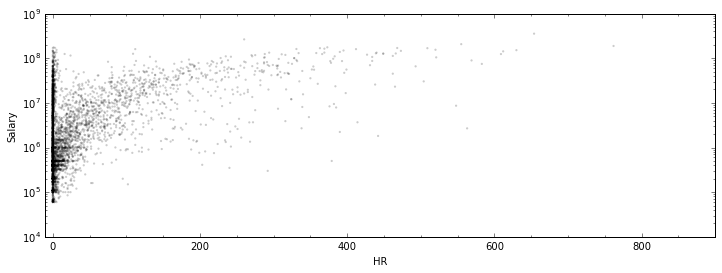

In [16]:
all_stats = pd.concat([total_hitting, total_salaries], axis=1)

all_stats_clean = all_stats.dropna()
plt.figure(figsize=(12,4))
plt.scatter(all_stats_clean.HR, all_stats_clean.salary, edgecolors='None', s=5, c='k', alpha=0.2)
plt.yscale('log')
plt.xlabel('HR')
plt.ylabel('Salary')
plt.minorticks_on()
plt.xlim(-10, 900)
plt.show()

Calculate a model for our data that best fits the relationship between homeruns and salary.

In [17]:
from sklearn import linear_model
import sklearn.cross_validation as cv

kfolds = cv.KFold(len(all_stats_clean), n_folds=10)

regressor = linear_model.LinearRegression()
Xvals = np.array(all_stats_clean.HR)[:, np.newaxis]
yvals = np.array(all_stats_clean.salary)

slopes, intercepts = [], []

for train_index, test_index in kfolds:
    X_train, X_test = Xvals[train_index], Xvals[test_index]
    y_train, y_test = yvals[train_index], yvals[test_index]
    regressor.fit(X_train, y_train)
    slopes.append(regressor.coef_)
    intercepts.append(regressor.intercept_)
    
slope = np.mean(slopes)
intercept = np.mean(intercepts)

regressor.coef_ = slope
regressor.intercept_ = intercept

print('Our model is: \n Salary = {} x N_HRs + {}'.format(slope, intercept))

Our model is: 
 Salary = 170662.04913058327 x N_HRs + 4510061.742907627


Plot the data with our model overlain.

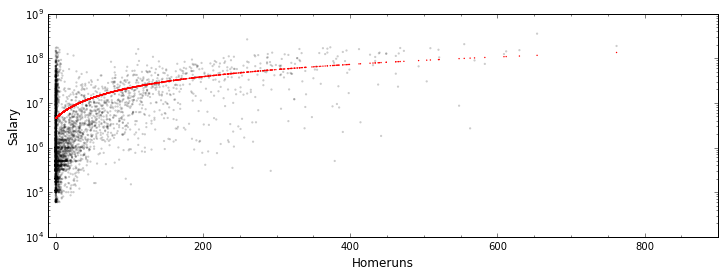

In [18]:
plt.figure(figsize=(12, 4))
plt.scatter(all_stats_clean.HR, all_stats_clean.salary, edgecolor='None', s=5, c='k', alpha=0.2)
plt.scatter(Xvals, regressor.predict(Xvals), edgecolor='None', s=2, c='r')
plt.yscale('log')
plt.xlabel('Homeruns', fontsize=12)
plt.ylabel('Salary', fontsize=12)
plt.minorticks_on()
plt.xlim(-10, 900)
plt.show()

In [19]:
print('Score: {}'.format(regressor.score(Xvals, yvals)))

Score: 0.32242071963063823


Our data is closer to zero which indicates that this model is not capturing our data with much accuracy.

Here we are going to calculate confidence intervals for salaries of players between 50 and 100 homeruns.

In [20]:
mean_salary = []
salary_50_100 = all_stats_clean[(all_stats_clean.HR >= 50) & (all_stats_clean.HR <= 100)]['salary']

for ii in range(10):
    X_train, X_test = cv.train_test_split(salary_50_100, test_size=0.33)
    mean_salary.append(np.mean(X_train))
    
the_validated_average_salary = np.mean(mean_salary)
print('Mean salary for players between 50 and 100 homeruns: ${}'.format(round(the_validated_average_salary,2)))

Mean salary for players between 50 and 100 homeruns: $10299476.84


In [21]:
sig = np.std(mean_salary)
print('Mean salary for players between 50 and 100 homeruns: ${}'.format(round(the_validated_average_salary,2)))
print('68% confidence interval: ${} - ${}'.format((round(the_validated_average_salary - sig,2)), round(the_validated_average_salary + sig,2)))
print('95% confidence interval: ${} - ${}'.format((round(the_validated_average_salary - sig*2,2)), round(the_validated_average_salary + sig*2,2)))
print('99.7% confidence interval: ${} - ${}'.format((round(the_validated_average_salary - sig*3,2)), round(the_validated_average_salary + sig*3,2)))

Mean salary for players between 50 and 100 homeruns: $10299476.84
68% confidence interval: $9840701.99 - $10758251.68
95% confidence interval: $9381927.15 - $11217026.53
99.7% confidence interval: $8923152.3 - $11675801.37


### Multivariant

Plot our data.

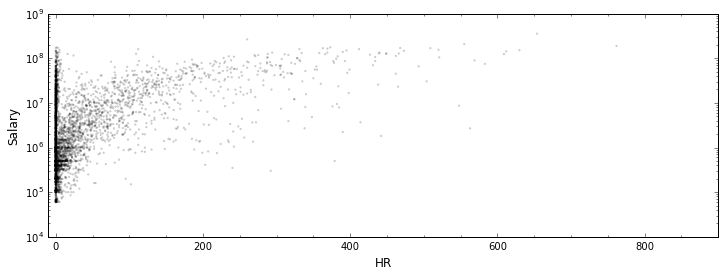

In [22]:
plt.figure(figsize=(12,4))
plt.scatter(all_stats_clean.HR, all_stats_clean.salary, edgecolors='None', s=5, c='k', alpha=0.2)
plt.yscale('log')
plt.xlabel('HR', fontsize=12)
plt.ylabel('Salary', fontsize=12)
plt.minorticks_on()
plt.xlim(-10, 900)
plt.show()

Design a multivariant model with runs, homeruns, rbis, and walks and calculate an R^2 score.

In [23]:
kfolds = cv.KFold(len(all_stats_clean), n_folds=10)

regressor = linear_model.LinearRegression()
Xvals = np.array(all_stats_clean[['R', 'HR', 'RBI', 'BB']])
yvals = np.array(all_stats_clean.salary)

coeffs, intercepts = [], []

for train_index, test_index in kfolds:
    X_train, X_test = Xvals[train_index], Xvals[test_index]
    y_train, y_test = yvals[train_index], yvals[test_index]
    regressor.fit(X_train, y_train)
    coeffs.append(regressor.coef_)
    intercepts.append(regressor.intercept_)
    
coeffs = np.array(coeffs).mean(axis=0)
intercept = np.array(intercepts).mean(axis=0)

regressor.coef_ = coeffs
regressor.intercept_ = intercept

In [24]:
print('Score: {}'.format(regressor.score(Xvals, yvals)))

Score: 0.3410419564927809


The multivariant score is slightly better than the univariant score at .34 vs .32.

Plot the homerun vs salary data vs our model predictions.

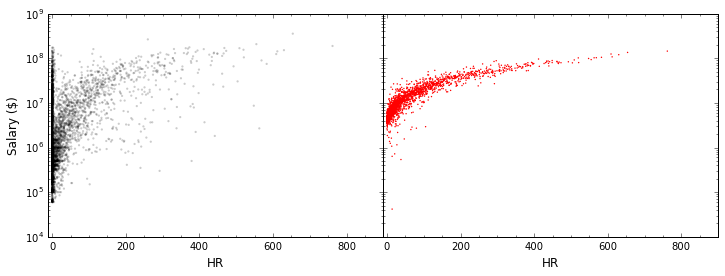

In [25]:
fig = plt.figure(figsize=(12, 4))
fig.subplots_adjust(wspace=0)
ax = plt.subplot(121)
ax.scatter(all_stats_clean.HR, all_stats_clean.salary, edgecolor="None",
            s=5, c='k', alpha=0.2)
ax.set_yscale("log")
ax.set_xlabel("HR", fontsize=12); ax.set_ylabel("Salary ($)", fontsize=12)
ax.set_xlim(-10, 900); ax.minorticks_on()

ax = plt.subplot(122)
ax.scatter(Xvals[:, 1], regressor.predict(Xvals), edgecolor="None",
            s=2, c='r')
ax.set_xlabel("HR", fontsize=12)
ax.set_ylim(1E4, 1E9)
ax.set_yscale("log"); ax.set_yticklabels([])
ax.set_xlim(-10, 900); ax.minorticks_on()

plt.show()

In conclusion, creating a salary model with batting stats is not the best because pitchers hit and they don't hit well, but they make a lot of money, but they are great at flegaling.

## Multivariant 

 #### Plot data with cols from batting, pitching, salaries files.

In [26]:
all_stats = pd.concat((total_batting, total_pitching, total_salaries), axis=1)
all_stats = all_stats[(all_stats.games > 0) & (all_stats.salary > 0)]
all_stats_clean = all_stats.dropna()

N_folds = 14
kfolds = cv.KFold(len(all_stats_clean), n_folds=N_folds)

regressor = linear_model.LinearRegression()
valid_data = ["strikeouts", "runs_allowed", "saves", "hits",
             "shutouts", "wins", "losses", "outs_pitched",
             "walks", "batters_faced", "at_bat", "Double", "Triple", "home_runs"]
Xvals = np.array(all_stats_clean[valid_data])
yvals = np.array(all_stats_clean.salary)

coeffs, intercepts = [], []

for train_index, test_index in kfolds:
    X_train, X_test = Xvals[train_index], Xvals[test_index]
    y_train, y_test = yvals[train_index], yvals[test_index]
    regressor.fit(X_train, y_train)
    coeffs.append(regressor.coef_)
    intercepts.append(regressor.intercept_)

coeffs = np.array(coeffs).mean(axis=0) #averages each column
intercept = np.array(intercepts).mean(axis=0)

regressor.coef_ = coeffs
regressor.intercept_ = intercept

#### Design model with strikeouts, runs_allowed, hits, outs_pitched, walks, batters_faced, at_bat and calculate an R^2 score

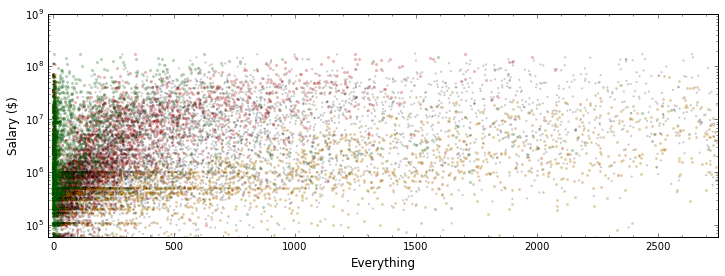

In [27]:
plt.figure(figsize=(12, 4))
plt.scatter(all_stats_clean.strikeouts, all_stats_clean.salary, edgecolor="None", s=5, c='k', alpha=0.2)
plt.scatter(all_stats_clean.runs_allowed, all_stats_clean.salary, edgecolor="Red", s=5, c='k', alpha=0.2)
plt.scatter(all_stats_clean.hits, all_stats_clean.salary, edgecolor="None", s=5, c='k', alpha=0.2)
plt.scatter(all_stats_clean.outs_pitched, all_stats_clean.salary, edgecolor="None", s=5, c='k', alpha=0.2)
plt.scatter(all_stats_clean.walks, all_stats_clean.salary, edgecolor="None", s=5, c='k', alpha=0.2)
plt.scatter(all_stats_clean.batters_faced, all_stats_clean.salary, edgecolor="Orange", s=5, c='k', alpha=0.2)
plt.scatter(all_stats_clean.at_bat, all_stats_clean.salary, edgecolor="Green", s=5, c='k', alpha=0.2)

# plt.scatter(Xvals[:, 1], regressor.predict(Xvals), color='r')

plt.yscale("log")
plt.xlabel("Everything", fontsize=12); plt.ylabel("Salary ($)", fontsize=12)
plt.minorticks_on()
plt.xlim(-20, 2750)
plt.ylim(60000)
plt.show()

In [29]:
print("Score: {0}".format(regressor.score(Xvals, yvals)))

Score: 0.7297115056758972


In [ ]:
#### Plot the homerun vs salary data vs our model predictions.

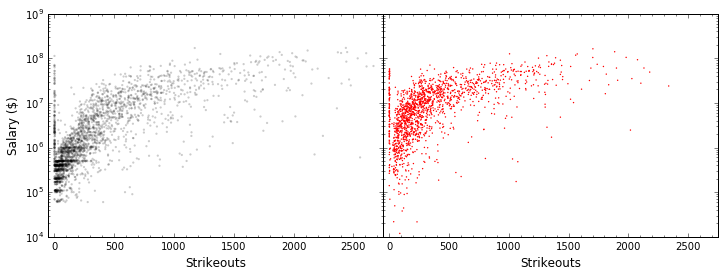

In [28]:
fig = plt.figure(figsize=(12, 4))
fig.subplots_adjust(wspace=0)
ax = plt.subplot(121)
ax.scatter(all_stats_clean.strikeouts, all_stats_clean.salary, edgecolor="None",
            s=5, c='k', alpha=0.2)
ax.set_yscale("log")
ax.set_xlabel("Strikeouts", fontsize=12); ax.set_ylabel("Salary ($)", fontsize=12)
ax.set_xlim(-50, 2750); ax.minorticks_on()

ax = plt.subplot(122)
ax.scatter(Xvals[:, 1], regressor.predict(Xvals), edgecolor="None",
            s=2, c='r')
ax.set_xlabel("Strikeouts", fontsize=12)
ax.set_ylim(1E4, 1E9)
ax.set_yscale("log"); ax.set_yticklabels([])
ax.set_xlim(-50, 2750); ax.minorticks_on()

plt.show()